In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle

from math import sqrt
from prediction_tools import error_analysis, get_youden_threshold, plot_confusion_matrix, \
    plot_prc, plot_roc, print_feature_weights, print_metrics, print_params
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

lr_estimator = LinearRegression()

param_grid = {
    'penalty': ['l1'],
    'C': np.logspace(-3, 3, 7),
    'class_weight': ['balanced'],
    'random_state': [60611],
    'solver': ['saga'],
    'max_iter': [1000]
}
clf = GridSearchCV(LogisticRegression(), param_grid, scoring='roc_auc', cv=4, n_jobs=-1)

# Read in data

In [2]:
X_train = pd.read_csv('train_data.csv') \
            .set_index(['subject_id', 'hadm_id', 'icustay_id'])
y_train_chl_110 = X_train['chl_110'].tolist()
X_train = X_train.drop(columns=['chloride_max', 'chl_110'])  # drop 'cluster'

X_test = pd.read_csv('test_data.csv') \
           .set_index(['subject_id', 'hadm_id', 'icustay_id'])
y_test_chl_110 = X_test['chl_110'].tolist()
X_test = X_test.drop(columns=['chloride_max', 'chl_110'])  # drop 'cluster'

print "%d features, %d training rows, %s test rows" % \
      (len(X_train.columns), len(X_train), len(X_test))

36 features, 23330 training rows, 9999 test rows


# Whole dataset

Selected parameters:
- C: 0.1
- solver: saga
- max_iter: 1000
- penalty: l1
- random_state: 60611
- class_weight: balanced
Coefficients:
                day_1_chl:  1.8856
           norepinephrine:  0.4829
              solid_tumor:  0.4724
       chloride_input_meq:  0.4264
                      age:  0.3575
                   gender:  0.3146
                    ASIAN:  0.2753
       MeanAirwayPressure:  0.2430
                paralysis:  0.2369
        fluid_electrolyte:  0.1958
 congestive_heart_failure:  0.1486
      cardiac_arrhythmias:  0.0253
                  obesity:  0.0116
            heartrate_max:  0.0057
                sysbp_min:  0.0049
                     IPAP:  0.0000
                 HISPANIC:  0.0000
         valvular_disease:  0.0000
    pulmonary_circulation:  0.0000
      peripheral_vascular:  0.0000
       other_neurological:  0.0000
        chronic_pulmonary:  0.0000
               drug_abuse:  0.0000
               diasbp_min: -0.0017
                    BLA

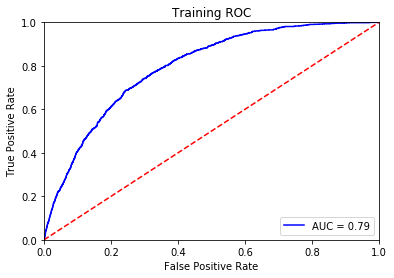

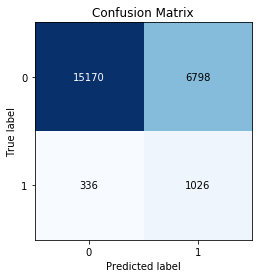

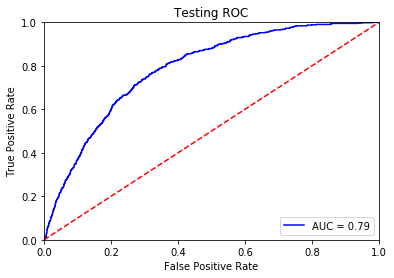

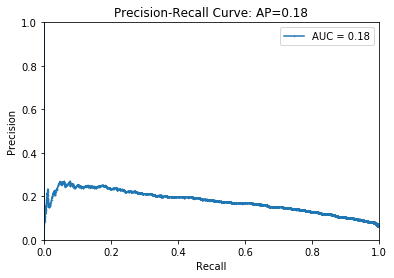

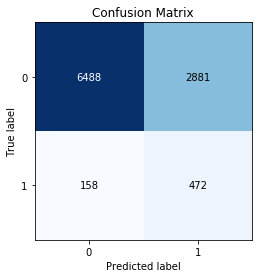

Precision:  0.14076946018490905
Recall   :  0.7492063492063492
F-measure:  0.23700728094401208


In [3]:
clf.fit(X_train, y_train_chl_110)
print_params(clf, param_grid.keys())
feature_weights = zip(X_train.columns, clf.best_estimator_.coef_.flatten())
print_feature_weights(feature_weights)

train_probabilities = clf.predict_proba(X_train)[:,1]
youden_threshold = get_youden_threshold(y_train_chl_110, train_probabilities)
plot_roc(y_train_chl_110, train_probabilities, "Training ROC")
# Used for error analysis
train_predictions = ((train_probabilities - youden_threshold) >= 0).astype(int)
plot_confusion_matrix(y_train_chl_110, train_predictions)

test_probabilities = clf.predict_proba(X_test)[:,1]
test_predictions = ((test_probabilities - youden_threshold) >= 0).astype(int)
plot_roc(y_test_chl_110, test_probabilities, "Testing ROC")
plot_prc(y_test_chl_110, test_probabilities)
print_metrics(y_test_chl_110, test_predictions)

# Error analysis

In [ ]:
with open("./error_analysis/scaler.pickle", 'rb') as f:
    to_standardize, scaler = pickle.load(f)

# It looks like the scaler has some precision problems when scaling
# back values of 0, so round to six decimals to address this.
X_train[to_standardize] = scaler.inverse_transform(X_train[to_standardize]).round(6)

error_analysis(X_train, y_train_chl_110, train_probabilities, export=True)

In [5]:
true_negatives = (np.array(y_train_chl_110) == 0) & (train_predictions == 0)
X_train.loc[true_negatives].to_csv('./error_analysis/true_negatives.csv')

false_positives = (np.array(y_train_chl_110) == 0) & (train_predictions == 1)
X_train.loc[false_positives].to_csv('./error_analysis/false_positives.csv')

# Pickle for combined plotting

In [6]:
with open('./pickle/lr_whole.pickle', 'wb') as f:
    # "Lasso" is only accurate if the L1 penalty is picked
    pickle.dump(("Lasso Regression", y_test_chl_110, test_probabilities), f)